# Challenge: advanced text extraction

Take the well-known [20 newsgroups dataset](http://qwone.com/~jason/20Newsgroups/) and use each of the methods on it. Your goal is to determine which method, if any, best reproduces the topics represented by the newsgroups. Write up a report where you evaluate each method in light of the 'ground truth'- the known source of each newsgroup post. Which works best, and why do you think this is the case?

Example code with this data set can be found at [this github](https://github.com/gokriznastic/20-newsgroups_text-classification/blob/master/Multinomial%20Naive%20Bayes-%20BOW%20with%20TF.ipynb). It was helpful to learn how to handle folders, subfolders, and files. 

In [1]:
# preprocessing tar files, organizing sub-folders and thier files
import tarfile
from os import listdir
from os.path import isfile, join
import string

import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# nlp parser
import spacy

import re

# vectorizing tfidf 
from sklearn.feature_extraction.text import TfidfVectorizer

In [1]:
# commented out because it only needs to be run once on a single machine

#fname='20_newsgroups (1).tar.gz'
#if fname.endswith("tar.gz"):
#    tar = tarfile.open(fname, "r:gz")
#    tar.extractall(path='C:/mypath/myfolder')
#    tar.close()
#elif fname.endswith("tar"):
#    tar = tarfile.open(fname, "r:")
#    tar.extractall(path='C:/mypath/myfolder')
#    tar.close()

In [2]:
my_path = '20_Newsgroups_Output/20_newsgroups'

#creating a list of folder names to make valid pathnames later
folders = [f for f in listdir(my_path)]

In [3]:
folders

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [4]:
len(folders)

20

In [5]:
#creating a 2D list to store list of all files in different folders

files = []
for folder_name in folders:
    folder_path = join(my_path, folder_name)
    files.append([f for f in listdir(folder_path)])

In [6]:
#checking total no. of files gathered

sum(len(files[i]) for i in range(len(files)))

19997

In [7]:
#creating a list of pathnames of all the documents
#this would serve to split our dataset into train & test later without any bias

pathname_list = []
for fo in range(len(folders)):
    for fi in files[fo]:
        pathname_list.append(join(my_path, join(folders[fo], fi)))

In [8]:
len(pathname_list)

19997

In [9]:
#making an array containing the classes each of the documents belong to

Y = []
for folder_name in folders:
    folder_path = join(my_path, folder_name)
    num_of_files= len(listdir(folder_path))
    for i in range(num_of_files):
        Y.append(folder_name)

In [10]:
len(Y)

19997

### Functions for word extraction from documents

In [12]:
#function to preprocess the words list to remove punctuations

def preprocess(words):
    #we'll make use of python's translate function,that maps one set of characters to another
    #we create an empty mapping table, the third argument allows us to list all of the characters 
    #to remove during the translation process
    
    #first we will try to filter out some  unnecessary data like tabs
    table = str.maketrans('', '', '\t')
    words = [word.translate(table) for word in words]
    
    punctuations = (string.punctuation).replace("'", "") 
    # the character: ' appears in a lot of stopwords and changes meaning of words if removed
    #hence it is removed from the list of symbols that are to be discarded from the documents
    trans_table = str.maketrans('', '', punctuations)
    stripped_words = [word.translate(trans_table) for word in words]
    
    #some white spaces may be added to the list of words, due to the translate function & nature of our documents
    #we remove them below
    words = [str for str in stripped_words if str]
    
    #some words are quoted in the documents & as we have not removed ' to maintain the integrity of some stopwords
    #we try to unquote such words below
    p_words = []
    for word in words:
        if (word[0] and word[len(word)-1] == "'"):
            word = word[1:len(word)-1]
        elif(word[0] == "'"):
            word = word[1:len(word)]
        else:
            word = word
        p_words.append(word)
    
    words = p_words.copy()
        
    #we will also remove just-numeric strings as they do not have any significant meaning in text classification
    words = [word for word in words if not word.isdigit()]
    
    #we will also remove single character strings
    words = [word for word in words if not len(word) == 1]
    
    #after removal of so many characters it may happen that some strings have become blank, we remove those
    words = [str for str in words if str]
    
    #we also normalize the cases of our words
    words = [word.lower() for word in words]
    
    #we try to remove words with only 2 characters
    words = [word for word in words if len(word) > 2]
    
    return words

In [13]:
# create stop words list
nlp = spacy.load('en')

stopwords = nlp.Defaults.stop_words

In [14]:
#function to remove stopwords

def remove_stopwords(words):
    words = [word for word in words if not word in stopwords]
    return words

In [15]:
#function to convert a sentence into list of words

def tokenize_sentence(line):
    words = line[0:len(line)-1].strip().split(" ")
    words = preprocess(words)
    words = remove_stopwords(words)
    
    return words

In [16]:
#function to remove metadata

def remove_metadata(lines):
    for i in range(len(lines)):
        if(lines[i] == '\n'):
            start = i+1
            break
    new_lines = lines[start:]
    return new_lines

In [17]:

#function to convert a document into list of words

def tokenize(path):
    #load document as a list of lines
    f = open(path, 'r')
    text_lines = f.readlines()
    
    #removing the meta-data at the top of each document
    text_lines = remove_metadata(text_lines)
    
    #initiazing an array to hold all the words in a document
    doc_words = []
    
    #traverse over all the lines and tokenize each one with the help of helper function: tokenize_sentence
    for line in text_lines:
        doc_words.append(tokenize_sentence(line))

    return doc_words

In [18]:
#a simple helper function to convert a 2D array to 1D, without using numpy

def flatten(list):
    new_list = []
    for i in list:
        for j in i:
            new_list.append(j)
    return new_list

In [19]:
# create list of words by applying a for loop and calling the flatten and tokenize functions
list_of_words = []

# results in lists of individual words inside lists for each document
for document in pathname_list:
        list_of_words.append(flatten(tokenize(document)))

In [20]:
len(list_of_words)

19997

In [21]:
# combine the words in the sub lists and store as strings 
# necessary to run text extraction model
sentences = []

for word_list in list_of_words:
    str1= " "
    
    sentence = str1.join(word_list)
    sentences.append(sentence)


In [22]:
len(sentences)

19997

# Comparing LSA, LDA, and NNMF

We'll be looking at interpretability, speed, and consistency across these text extraction methods.  The goal is to identify common themes in sentences on a per-document basis.  We won't be using pLSA as sklearn does not support it.

To do this, we will:

1. Parse and process the data into a tf-idf matrix.
2. Fit LSA, LDA, and NNMF models with 5 topics each.
4. Extract the words that best describe each topic.
5. Examine the topic relationships for the words 'god', 'thanks', 'people', and 'writes'.

## Generating the tfidf matrix

In [24]:
# Creating the tf-idf matrix.
vectorizer = TfidfVectorizer(stop_words='english')
sentences_tfidf=vectorizer.fit_transform(sentences)

# Getting the word list.
terms = vectorizer.get_feature_names()

# Number of topics.
ntopics=5

# Linking words to topics
def word_topic(tfidf,solution, wordlist):
    
    # Loading scores for each word on each topic/component.
    words_by_topic=tfidf.T * solution

    # Linking the loadings to the words in an easy-to-read way.
    components=pd.DataFrame(words_by_topic,index=wordlist)
    
    return components

# Extracts the top N words and their loadings for each topic.
def top_words(components, n_top_words):
    n_topics = range(components.shape[1])
    index= np.repeat(n_topics, n_top_words, axis=0)
    topwords=pd.Series(index=index)
    for column in range(components.shape[1]):
        # Sort the column so that highest loadings are at the top.
        sortedwords=components.iloc[:,column].sort_values(ascending=False)
        # Choose the N highest loadings.
        chosen=sortedwords[:n_top_words]
        # Combine loading and index into a string.
        chosenlist=chosen.index +" "+round(chosen,2).map(str) 
        topwords.loc[column]=[x for x in chosenlist]
    return(topwords)

# Number of words to look at for each topic.
n_top_words = 10


In addition to creating the tfidf matrix, there are two convenience functions that will help keep the code tidy when comparing models.  The first provides a list of the words that are paired with each topic.  The second gives us the best words for each topic so we can compare across methods.

## Fitting the three topic extraction models

In [25]:
# LSA

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

svd= TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))
sentences_lsa = lsa.fit_transform(sentences_tfidf)

components_lsa = word_topic(sentences_tfidf, sentences_lsa, terms)

topwords=pd.DataFrame()
topwords['LSA']=top_words(components_lsa, n_top_words)     

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [26]:
# LDA
from sklearn.decomposition import LatentDirichletAllocation as LDA

lda = LDA(n_components=ntopics, # n_topics is depreciated
          doc_topic_prior=None, # Prior = 1/n_documents
          topic_word_prior=1/ntopics,
          learning_decay=0.7, # Convergence rate.
          learning_offset=10.0, # Causes earlier iterations to have less influence on the learning
          max_iter=10, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=-1, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
          random_state=0
         )

sentences_lda = lda.fit_transform(sentences_tfidf) 

components_lda = word_topic(sentences_tfidf, sentences_lda, terms)

topwords['LDA']=top_words(components_lda, n_top_words)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [27]:
# NNMF

from sklearn.decomposition import NMF

nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
sentences_nmf = nmf.fit_transform(sentences_tfidf) 

components_nmf = word_topic(sentences_tfidf, sentences_nmf, terms)

topwords['NNMF']=top_words(components_nmf, n_top_words)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


We are mostly using the default settings for each method, but explicitly printing them so it is clear what is going on and how each model can be modified.  sklearn has such nice parallel structure for its various topic extraction methods that we could probably have abstracted the code even further.

In [28]:
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords.loc[topic])

Topic 0:
              LSA             LDA             NNMF
0   writes 287.51   thanks 108.55      people 7.65
0  article 263.32  windows 103.83      writes 6.31
0      don 223.32      know 85.47     article 5.94
0     like 219.94     email 85.15         don 5.58
0     know 214.55       use 83.89  government 4.91
0   people 206.75     drive 82.31        like 4.71
0    think 179.47      card 77.94        think 4.6
0      use 150.74      like 76.12        know 4.03
0     good 148.02    writes 69.45       right 3.81
0     time 146.76   article 63.45        time 3.32
Topic 1:
              LSA           LDA          NNMF
1   thanks 101.78   writes 9.82  windows 7.51
1   windows 88.78  article 9.11   thanks 6.26
1      email 76.1     know 8.34    drive 6.01
1      card 67.28   thanks 8.33     card 5.26
1     drive 64.51     like 7.45      use 5.02
1       use 53.07      don 7.06     know 4.94
1      file 50.26    email 6.83    email 4.86
1  software 48.72    people 6.0     like 4.49
1   pro

A number of things are clear.  First, some topics are shared, though the order of topics varies- the 'writes' topic is first for LSA, but second for LDA.  And second, the content of some of the topics varies considerably across methods.  This is a clear argument for using multiple methods when exploring topics.

# Sparsity

Now let's examine sparsity by looking at the distributions of loadings for the words 'god', 'thanks', 'people', and 'writes' across the methods:

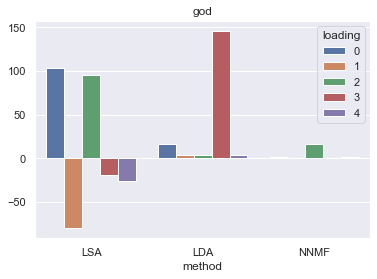

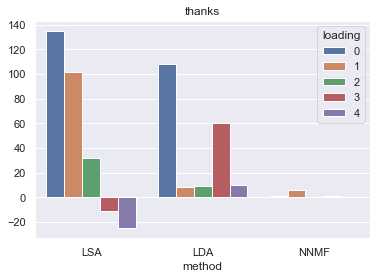

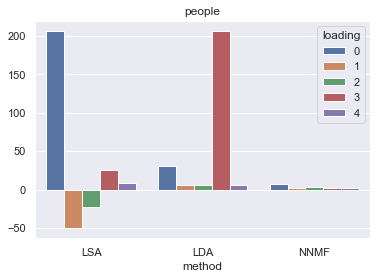

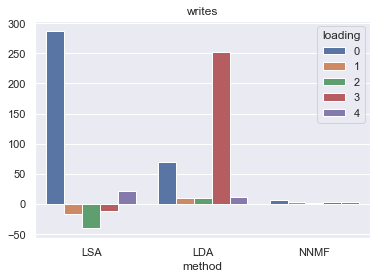

In [29]:
# The words to look at.
targetwords=['god','thanks','people','writes']

# Storing the loadings.
wordloadings=pd.DataFrame(columns=targetwords)

# For each word, extracting and string the loadings for each method.
for word in targetwords:
    loadings=components_lsa.loc[word].append(
        components_lda.loc[word]).append(
            components_nmf.loc[word])
    wordloadings[word]=loadings

# Labeling the data by method and providing an ordering variable for graphing purposes. 
wordloadings['method']=np.repeat(['LSA','LDA','NNMF'], 5, axis=0)
wordloadings['loading']=[0,1,2,3,4]*3

sns.set(style="darkgrid")

for word in targetwords:
    sns.barplot(x="method", y=word, hue="loading", data=wordloadings)
    plt.title(word)
    plt.ylabel("")
    plt.show()

LSA is the method most likely to have high loadings on more than one topic for the same word, and negative loadings.  LDA tends to have one high loading and some lower loadings.  Loadings for NNMF are lower all around, and the most sparse, with some of the topics having loadings of zero on each word.